# Chapter 8: Text

Accompanying code for the book [The Art of Feature Engineering](http://artoffeatureengineering.com).

This notebook plus notebooks for the other chapters are available online at https://github.com/DrDub/artfeateng


## MIT License

Copyright 2019 Pablo Duboue

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Limitations

* Simple python intented for people coming from other languages that plan to use the ideas described in the book outside of Python.
* Many of these techniques are available as library calls. They are spelled out as for teaching purposes.
* Resource limitations:
 * At most one day of running time per notebook.
 * No GPU required.
 * Minimal dependencies.
 * At most 8Gb of RAM.
* Due to resource limitations, these notebooks do not undergo as much hyperparameter tuning as necessary. This is a shortcoming of these case studies, keep it in mind if you want to follow a similar path with your experiments.
* To help readers try variants of some cells in isolation, the cells are easily executable without having to re-run the whole notebook. As such, most cells read everything they need from disk and write all their results back into disk, which is unnecessary with normal notebooks. The code for each cell might look long and somewhat unusual. In a sense, each cell tries to be a separate Python program.
* I dislike Pandas so these notebooks are Pandas-free, which might seem unusual to some.

# Chapter 8: Case Study on Textual Data

In this chapter, we will cover an expansion of the WikiCities dataset with textual descriptions and its impact on the population prediction task introduced in Chapter 6.

Text is a domain that exemplifies:

* Large number of correlated features
* A domain where ordering issues are important
* Variable length feature vectors

Among the methods exemplified in text we will see:

* Feature selection: dimensionality reduction
* Feature weighting: TF-IDF
* Computable features: morphological features

## WikiCities Text Dataset

The text data we will be using in this notebook are the Wikipedia pages for the different cities in the dataset. Text extraction from Wikipedia is a computationally intense task and better catered by specialized tools. In this case, I used the excellent software [wikiextractor](https://github.com/attardi/wikiextractor) by Giuseppe Attardi and produces cities1000_wikitext.tsv.bz2, with one city per row and text lines separated by tab characters. That 43,909,804 words and over 270,902,780 characters (average of 558 words per document, 3,445 characters) . For some of the experiments using document structure, I also kept the original markup in file cities1000_wikiraw.tsv.bz2, with markup the total number of characters climbs above 730 million.

First, many Wikipedia pages contain the population information mentioned within the text. Not necessarily all of them, but many do. At the Exploratory Data Analysis stage we might want to get an idea of how many do. Even for the ones that do, however, it might be indicated in many different ways, including punctuation (2,152,111 instead of 2152111) but most probably rounded up and expressed intermixing digits with words (like "a little over 2 million"). In that sense, this task is representative of the NLP subfield of Information Extraction.

While NLP this decade has been overtaken by Deep Learning approaches, particularly using Neurolanguage Models, this particular task most probably can still profit from non-deep learning techniques as we are looking for a very small piece of evidence within a large amount of data.

Following Chapter 6, it is clear that bigger cities will have longer pages so text length will most probably be a great feature. As base features, we will use the ch6_cell32_dev_feat_conservative.tsv with its 98 features.

With such an amount of data, aggressive feature selection will be needed, but let us start with some EDA.

## Exploratory Data Analyis

Let us start by assembling a simple data set with an extra feature (the text length) and see whether it helps better predict the population (Cell #1)

Training on 35,971 cities
RMSE 0.3434770677131145


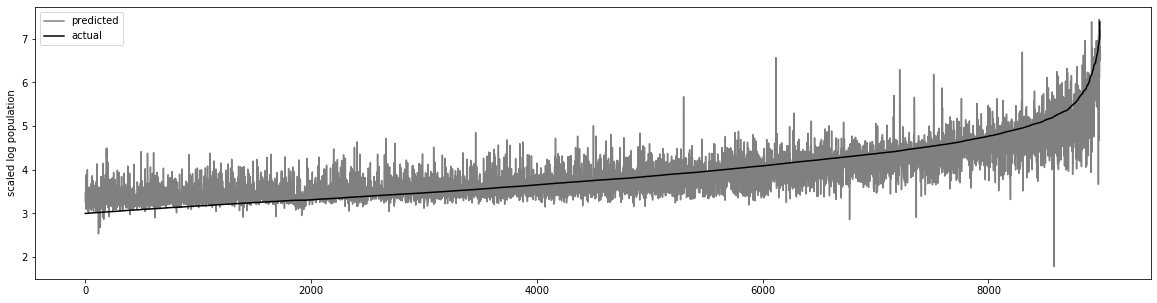

In [1]:
# CELL 1
import random
import bz2
import re
import math
from sklearn.svm import SVR
import numpy as np

# read page lengths
text_lengths = dict()
with bz2.BZ2File("cities1000_wikitext.tsv.bz2","r") as wikitext:
    for byteline in wikitext:
        cityline = byteline.decode("utf-8")
        tab = cityline.index('\t')
        name = cityline[:tab]
        text = cityline[tab:]
        text_lengths[name] = len(text)

# read base features
rand = random.Random(42)
train_data = list()
test_data  = list()
header = None
with open("ch8_cell1_dev_textlen.tsv", "w") as ch8:
    with open("ch6_cell32_dev_feat_conservative.tsv") as feats:
        header = next(feats)
        header = header.strip().split("\t")
        header.insert(-1, 'logtextlen')
        ch8.write("\t".join(header) + "\n")
        header.pop(0) # name
        header.pop() # population
        for line in feats:
            fields = line.strip().split("\t")
            if name not in text_lengths:
                raise Exception("City not found: " + name)
            fields.insert(-1, str(math.log(text_lengths[name], 10)))
            ch8.write("\t".join(fields) + "\n")
            logpop = float(fields[-1])
            name = fields[0]
            feats = list(map(float,fields[1:-1]))
            row = (feats, logpop, name)
            if rand.random() < 0.2:
                test_data.append(row) 
            else:
                train_data.append(row)

test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))
train_data = None
test_data  = None

# SVRs need scaling
xtrain_min = xtrain.min(axis=0); xtrain_max = xtrain.max(axis=0)
# some can be zero if the column is constant in training
xtrain_diff = xtrain_max - xtrain_min
for idx in range(len(xtrain_diff)):
    if xtrain_diff[idx] == 0.0:
        xtrain_diff[idx] = 1.0
xtrain_scaling = 1.0 / xtrain_diff
xtrain -= xtrain_min; xtrain *= xtrain_scaling

ytrain_min = ytrain.min(); ytrain_max = ytrain.max()
ytrain_scaling = 1.0 / (ytrain_max - ytrain_min)
ytrain -= ytrain_min; ytrain *= ytrain_scaling

xtest -= xtrain_min; xtest *= xtrain_scaling
ytest_orig = ytest.copy()
ytest -= ytrain_min; ytest *= ytrain_scaling

# train
print("Training on {:,} cities".format(len(xtrain)))

best_c       = 100.0
best_epsilon = 0.05
svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
svr_rbf.fit(xtrain, ytrain)
ytest_pred  = svr_rbf.predict(xtest)
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

xtrain = None
xtest  = None

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest_orig, label="actual",    color='black')
plt.ylabel('scaled log population')
plt.savefig("ch8_cell1_svr.pdf", bbox_inches='tight', dpi=300)
plt.legend()

The resulting RMSE of 0.3434 is an improvement of the one from Chapter 6, 0.3578, which is encouraging, but it is above using the full Chapter 6 graph information at 0.3298. 

Let us look at ten random cities to see whether their text descriptions include the population explicitly (Cell #2). Notice I have used a regular Wikipedia dump, not a Cirrus dump. Wikipedia in recent years have moved to include tags expanded from the Wikidata project and therefore the exact population number might be absent, with a tag indicating the template engine to fetch the number at rendering time.

In [2]:
# CELL 2
PARAM_USE_SET_FOR_BOOK = True

cities_and_pop = list()
with open("ch8_cell1_dev_textlen.tsv") as feats:
    first = True
    for line in feats:
        if first:
            first = False
        else:
            fields = line.split('\t')
            cities_and_pop.append( (fields[0], round(10**float(fields[-1]))) )

rand = random.Random(42)

# stable set for book
cities = [ ('Century,_Florida', 1698), ('Isseksi', 2000), ('Volda', 8827), ('Cournonsec', 2149), 
          ('Cape_Neddick,_Maine', 2568), ('Zhlobin', 80200), ('Hangzhou', 9018000), ('Gnosall', 4736), 
          ('Scorbé-Clairvaux', 2412), ('Arizona_City,_Arizona>', 10475) ]

if PARAM_USE_SET_FOR_BOOK:
    cities = list(map(lambda x: ("<http://dbpedia.org/resource/" + x[0] + ">", x[1]), cities))
else:
    cities = set(rand.sample(sorted(cities_and_pop), 10))
    
to_print = set(map(lambda x:x[0], cities))
pops = { x[0]: x[1] for x in cities }

html = ''
with bz2.BZ2File("cities1000_wikitext.tsv.bz2","r") as wikitext:
    for byteline in wikitext:
        cityline = byteline.decode("utf-8")
        tab = cityline.index('\t')
        name = cityline[:tab]
        if name in to_print:
            text = cityline[tab:]
            text = text.replace('\t','<p>')
            html += "<h1>{}</h1><h2>Population: {}</h2>{}".format(name[1:-1], pops[name], text)
from IPython.display import HTML, display
display(HTML(html))

From here, most pages mention the actual number, albeit with punctuation.

<table>
    <tr><th>City</th><th>Pop</th><th>Text</th></tr>
    <tr><td>Arizona_City,_Arizona</td><td></td><td>The population was 10,475 at the 2010 census.</td></tr>
    <tr><td>Century,_Florida</td><td></td><td>The population was 1,698 at the 2010 United States Census.</td></tr>
    <tr><td>Cape_Neddick,_Maine</td><td></td><td>The population was 2,568 at the 2010 census.</td></tr>
    <tr><td>Hangzhou</td><td></td><td>Hangzhou prefecture had a registered population of 9,018,000 in 2015.</td></tr>
    <tr><td>Volda</td><td>8827</td><td>The new Volda municipality had 7,207 residents.</td></tr>
    <tr><td>Gnosall</td><td></td><td>Gnosall Gnosall is a village and civil parish in the Borough of Stafford, Staffordshire, England, with a population of 4,736 across 2,048 households (2011 census).</td></tr>
    <tr><td>Zhlobin</td><td></td><td>As of 2012, the population is 80.200.</td></tr>
    <tr><td>Cournonsec</td><td>2149</td><td></td></tr>
    <tr><td>Scorbé-Clairvaux</td><td>2412</td><td></td></tr>
    <tr><td>Isseksi</td><td></td><td>At the time of the 2004 census, the commune had a total population of 2000 people living in 310 households.</td></tr>
</table>

So 8 out of 10 mention the population, with one case of a different population (7,207 vs. 8,827) and another with the wrong punctuation (80.200 instead of 80,200). Clearly there is value on the textual data. Only one case it has the number verbatim (without any punctuation).

Also, note that Volda is town with plenty of text and a rich history. The page itself describes its population changes over the years.

Let us see if these percentages carry on to the whole dataset (Cell #3).

In [3]:
# CELL 3
import bz2

cities_and_pop = dict()
with open("ch6_cell32_dev_feat_conservative.tsv") as feats:
    first = True
    for line in feats:
        if first:
            first = False
        else:
            fields = line.split('\t')
            cities_and_pop[ fields[0] ] = round(10**float(fields[-1]))

found_verbatim    = 0
found_with_commas = 0
found_with_dots   = 0
total = 0
with bz2.BZ2File("cities1000_wikitext.tsv.bz2","r") as wikitext:
    for byteline in wikitext:
        cityline = byteline.decode("utf-8")
        tab = cityline.index('\t')
        name = cityline[:tab]
        text = cityline[tab:]
        if name in cities_and_pop:
            total += 1
            pop = cities_and_pop[name]
            pop_verbatim = str(pop)
            if pop_verbatim in text:
                found_verbatim += 1
            else:
                pop_commas = "{:,}".format(pop)
                if pop_commas in text:
                    found_with_commas += 1
                else:
                    pop_dots = pop_commas.replace(",",".")
                    if pop_dots in text:
                        found_with_dots += 1

print("Total cities:      {:,}".format(total))
print("Found verbatim:    {:,} ({:%})".format(found_verbatim, found_verbatim * 1.0 / total))
print("Found with commas: {:,} ({:%})".format(found_with_commas, found_with_commas * 1.0 / total))
print("Found with dots:   {:,} ({:%})".format(found_with_dots, found_with_dots * 1.0 / total))
found_either = found_verbatim + found_with_commas + found_with_dots
print("Found either:      {:,} ({:%})".format(found_either, found_either * 1.0 / total))

Total cities:      44,959
Found verbatim:    1,379 (3.067239%)
Found with commas: 22,647 (50.372562%)
Found with dots:   36 (0.080073%)
Found either:      24,062 (53.519874%)


Therefore, half the cities contain their population verbatim in the page. Using rule-based information extraction techniques (regular expressions and the like), for example using the [Rule-based Text Annotation](https://uima.apache.org/ruta.html) system would work. We will try more automated techniques based which might also apply for the other cities.

A question is what type of model to use. This might be a good moment to move away from SVRs, as they could have trouble with large number of features and their strong tendency against overfitting might fail when any of those features contain the target value, so let us see how it behaves with a target leak. (Cell #4).

Training on 35,971 cities
RMSE with target leak 0.10537655348694651


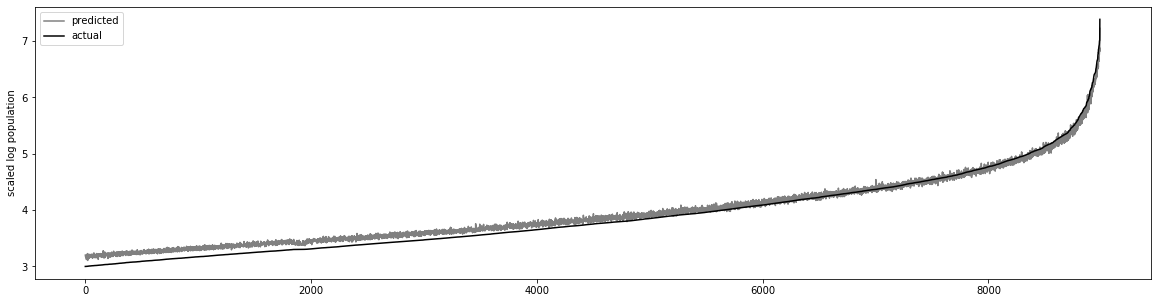

In [4]:
# CELL 4
import random
import re
import math
from sklearn.svm import SVR
import numpy as np

# read base features
rand = random.Random(42)
train_data = list()
test_data  = list()
header = None
with open("ch8_cell1_dev_textlen.tsv") as feats:
    header = next(feats)
    header = header.strip().split("\t")
    header.pop(0) # name
    for line in feats:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:])) # keep pop
        row = (feats, logpop, name)
        if rand.random() < 0.2:
            test_data.append(row) 
        else:
            train_data.append(row)

test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))
train_data = None
test_data  = None

# SVRs need scaling
xtrain_min = xtrain.min(axis=0); xtrain_max = xtrain.max(axis=0)
# some can be zero if the column is constant in training
xtrain_diff = xtrain_max - xtrain_min
for idx in range(len(xtrain_diff)):
    if xtrain_diff[idx] == 0.0:
        xtrain_diff[idx] = 1.0
xtrain_scaling = 1.0 / xtrain_diff
xtrain -= xtrain_min; xtrain *= xtrain_scaling

ytrain_min = ytrain.min(); ytrain_max = ytrain.max()
ytrain_scaling = 1.0 / (ytrain_max - ytrain_min)
ytrain -= ytrain_min; ytrain *= ytrain_scaling

xtest -= xtrain_min; xtest *= xtrain_scaling
ytest_orig = ytest.copy()
ytest -= ytrain_min; ytest *= ytrain_scaling

# train
print("Training on {:,} cities".format(len(xtrain)))

best_c       = 100.0
best_epsilon = 0.05
svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
svr_rbf.fit(xtrain, ytrain)
ytest_pred  = svr_rbf.predict(xtest)
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
print("RMSE with target leak", RMSE)

xtrain = None
xtest  = None

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest_orig, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch8_cell4_svr.pdf", bbox_inches='tight', dpi=300)
plt.legend()

That looks actually very nice, sadly, when adding more features the training times get prohibitively long, so I moved to a Random Forest Regressor (Cell #5).

Training on 35,971 cities
RMSE 0.3547396128278879


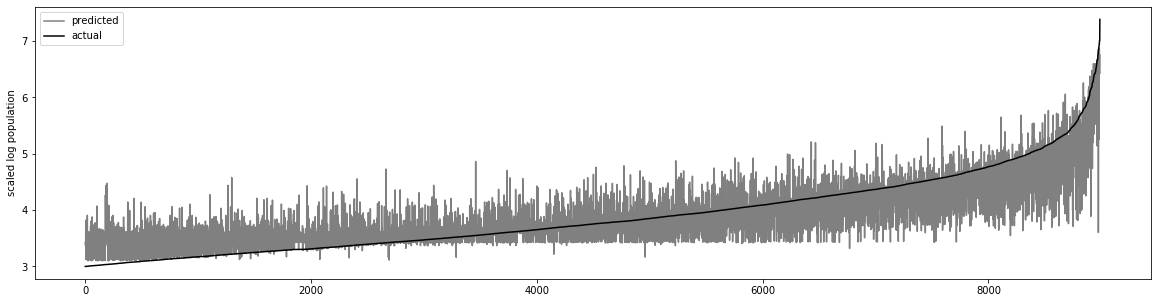

In [5]:
# CELL 5
import re
import random
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np


# read base features
rand = random.Random(42)
header = None
train_data = list()
test_data  = list()
with open("ch8_cell1_dev_textlen.tsv") as f:
    header = next(f)
    header = header.strip().split("\t")
    header.pop(0) # name
    header.pop() # population
    for line in f:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        row = (feats, logpop, name) 
        if rand.random() < 0.2:
            test_data.append(row) 
        else:
            train_data.append(row)

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))
train_data = None
test_data  = None

# train
print("Training on {:,} cities".format(len(xtrain)))

rf = RandomForestRegressor(max_features=0.75, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rf.fit(xtrain, ytrain)
ytest_pred = rf.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

xtrain = None
xtest  = None

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest,      label="actual",    color='black')
plt.ylabel('scaled log population')
plt.savefig("ch8_cell5_rf.pdf", bbox_inches='tight', dpi=300)
plt.legend()

It produces worse performance than SVR but it trains much faster so it will do. We can now proceed to our first featurization, where we will see the documents as bags of words.

## First Featurization: Numbers-only

The bag of words approach represents each document as a fixed size vector with size equals to the whole vocabulary (as computed on training).

By far the most important function in a bag-of-words approach is the tokenization function. Good tokenization is key and it is language and subdomain specific (e.g., journalistic text vs. Twitter).

In our case, tokenizing numbers is key. In other domains it is important to find different variations of words (what is known as "morphology") but this problem presents a simpler case, just with numbers.

For the purpose of our regression problem, a difference between 12,001,112 and 12,001,442 constitutes a _nuisance variation_ and needs to be addressed. We can replace each number with a pseudo-word, indicating, for example, how many digits the number has (think "TOKNUM1DIGIT", "TOKNUM2DIGIT", etc). That will produce about 10 tokens for all the population numbers we have. This might not be enough, instead we might want to distinguish the first digit of the numbers (1TOKNUM3DIGIT represents 1,000 to 1,999; 2TOKNUM3DIGIT represent 2,000 to 2,999 and so one), that will create about 90 tokens, which might be too many.

Instead, we can use the discretization data from Cell #27 in Chapter 6 and transform each number-like token into a TOKNUMSEG1 for 32 segments (Cell #5 below). To avoid having too many features, we are going to expand the feature vector to include only binary features indicating whether these features appear.

### Word classes vs. word tokens

When operating with documents and vocabularies, it is important to distinguish the vocabulary size vs. the total document sizes. Both are measured in "words" but the term "word" means different things in each case. Therefore, in NLP we use the terms "word types" to refers to dictionary entries and "word tokens" to refer to document entries. You can think of the word types as a class in object oriented programming and a word token as an instance of the class.

We can now assemble the baseline system, where we are using BoW over the whole documents in the trainset. Because the vocabulary is fixed in the trainset, there will be many words missing in the devset. That is when smoothing techniques (like Good-Turing's smoothing) come handy.

Training on 35,971 cities
RMSE 0.3437545061225639


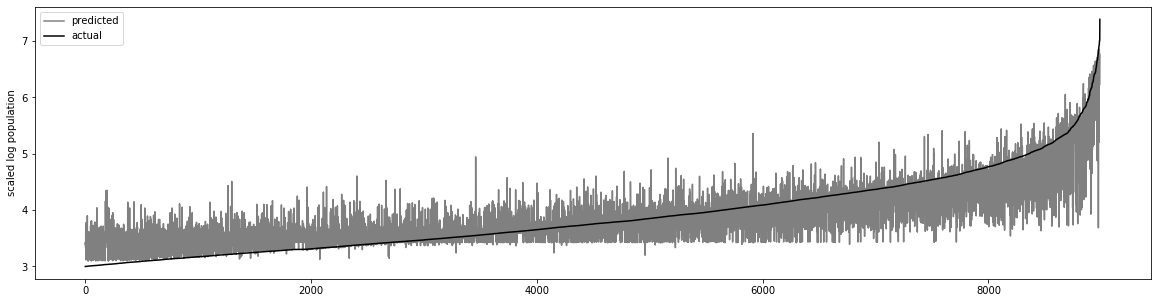

In [6]:
# CELL 6
import re
import pickle
import random
import bz2
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np

with open("ch6_cell27_splits.pk", "rb") as pkl:
    segments_at = pickle.load(pkl)

boundaries = list(map(lambda x:( int(round(10**x['min'])), 
                            int(round(10**x['val'])), 
                            int(round(10**x['max'])) ), segments_at[5]))
                
NUM_RE = re.compile('\d?\d?\d?(,?\d{3})+') # at least 3 digits
def cell6_tokenize(text):
    tokens = list(filter(lambda x:len(x)>0, 
                         re.sub('\s+',' ', re.sub('[^A-z,0-9]', ' ', text)).split(' ')))
    result = list()
    for tok in tokens:
        if tok[-1] in set([".", ",", "?", "!"]):
            tok = tok[:-1]
        if NUM_RE.fullmatch(tok):
            num = int(tok.replace(",",""))
            if num < boundaries[0][0]:
                pass # too small
            elif num > boundaries[-1][2]:
                pass # too big
            else:
                found = False
                for idx, seg in enumerate(boundaries[1:]):
                    if num < seg[0]:
                        result.append("TOKNUMSEG" + str(idx))
                        found = True
                        break
                if not found:
                    result.append("TOKNUMSEG" + str(len(boundaries) - 1))
    return result

# read base features
rand = random.Random(42)
all_data = list()
city_to_all_data = dict()
header = None
with open("ch8_cell1_dev_textlen.tsv") as f:
    header = next(f)
    header = header.strip().split("\t")
    header.pop(0) # name
    header.pop() # population
    for line in f:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        city_to_all_data[name] = len(all_data)
        all_data.append( (feats, logpop, name) )
                
# add text features
tok_to_col = dict()
for idx, segs in enumerate(boundaries):
    header.append("TOKNUMSEG{}-{}-{}".format(idx, segs[0], segs[-1]))
    tok_to_col["TOKNUMSEG{}".format(idx)] = idx
    
remaining = set(map(lambda x:x[-1], all_data))
with bz2.BZ2File("cities1000_wikitext.tsv.bz2","r") as wikitext:
    for byteline in wikitext:
        cityline = byteline.decode("utf-8")
        tab = cityline.index('\t')
        name = cityline[:tab]
        if name in remaining:
            remaining.remove(name)
            extra_feats = [0.0] * len(boundaries)
            text = cityline[tab:]
            for numtoken in cell6_tokenize(text):
                extra_feats[tok_to_col[numtoken]] = 1.0
            all_data[city_to_all_data[name]][0].extend(extra_feats)
            
for name in remaining:
    extra_feats = [0.0] * len(boundaries)
    all_data[city_to_all_data[name]][0].extend(extra_feats)

with open("ch8_cell6_dev_feat1.tsv", "w") as feats:
    extheader = header.copy()
    extheader.insert(0, 'name')
    extheader.append('logpop')
    feats.write("\t".join(extheader) + "\n")
    for row in all_data:
        feats.write("{}\t{}\t{}\n".format(row[-1], "\t".join(map(str,row[0])), row[1]))
    
# split
train_data = list()
test_data  = list()
for row in all_data:
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)

test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))
train_data = None
test_data  = None

# train
print("Training on {:,} cities".format(len(xtrain)))

rf = RandomForestRegressor(max_features=0.75, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rf.fit(xtrain, ytrain)
ytest_pred = rf.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

xtrain = None
xtest  = None

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest,      label="actual",   color='black')
plt.ylabel('scaled log population')
plt.savefig("ch8_cell6_rf_feat1.pdf", bbox_inches='tight', dpi=300)
plt.legend()

At 0.3437, that worked very well for adding only 32 new features, but we are still not at the level of the SVR (a SVR on this dataset takes 2h to train, with only 130 features and produce a RMSE of 0.3216). 

## Second Featurization: Bag-of-words

Let's try to add some more words to build a BoW representation, to avoid a large feature set, let's take the top 1000 words filtered by M.I. (Cell #7)

In [7]:
# CELL 7
import re
import pickle
import random
import bz2
import math
import numpy as np

with open("ch6_cell27_splits.pk", "rb") as pkl:
    segments_at = pickle.load(pkl)

boundaries = list(map(lambda x:( int(round(10**x['min'])), 
                            int(round(10**x['val'])), 
                            int(round(10**x['max'])) ), segments_at[5]))
                
NUM_RE = re.compile('\d?\d?\d?(,?\d{3})+') # at least 3 digits
def cell7_tokenize(text):
    tokens = list(filter(lambda x:len(x)>0, 
                         re.sub('\s+',' ', re.sub('[^A-z,0-9]', ' ', text)).split(' ')))
    result = list()
    for tok in tokens:
        if len(tok) > 1 and tok[-1] in set([".", ",", "?", "!", "\"", "'"]):
            tok = tok[:-1]
        if NUM_RE.fullmatch(tok):
            num = int(tok.replace(",",""))
            if num < boundaries[0][0]:
                result.append("TOKNUMSMALL")
            elif num > boundaries[-1][2]:
                result.append("TOKNUMBIG")
            else:
                found = False
                for idx, seg in enumerate(boundaries[1:]):
                    if num < seg[0]:
                        result.append("TOKNUMSEG" + str(idx))
                        found = True
                        break
                if not found:
                    result.append("TOKNUMSEG" + str(len(boundaries) - 1))
        else:
            result.append(tok.lower())
    return result

# read base features
rand = random.Random(42)
city_pop = dict()
with open("ch8_cell1_dev_textlen.tsv") as f:
    header = next(f)
    for line in f:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        city_pop[name] = logpop
cities = sorted(list(city_pop.keys()))
        
# vocabulary
all_vocab     = list()
vocab_to_idx  = dict()
city_tok_idxs = dict()

remaining = set(city_pop.keys())
with bz2.BZ2File("cities1000_wikitext.tsv.bz2","r") as wikitext:
    for byteline in wikitext:
        cityline = byteline.decode("utf-8")
        tab = cityline.index('\t')
        name = cityline[:tab]
        if name in remaining:
            if (len(cities) - len(remaining)) % int(len(cities) / 10) == 0:
                print("Tokenizing {:>5} out of {:>5} cities, city \"{}\""
                      .format((len(cities) - len(remaining)), len(cities), name))
            remaining.remove(name)
            text = cityline[tab:]
            toks = set()
            for token in cell7_tokenize(text):
                idx = vocab_to_idx.get(token, None)
                if idx is None:
                    idx = len(all_vocab)
                    all_vocab.append(token)
                    vocab_to_idx[token] = idx
                toks.add(idx)
            city_tok_idxs[name] = sorted(list(toks))

for name in remaining:
    city_tok_idxs[name] = list()
    
print("Total vocabulary: {:,}".format(len(all_vocab)))

# drop tokens that appear in less than 200 documents
tok_docs = list()
for _ in range(len(all_vocab)):
    tok_docs.append([])
for doc_idx, name in enumerate(cities):
    tok_idxs = city_tok_idxs[name]
    for tok_idx in tok_idxs:
        tok_docs[tok_idx].append(doc_idx)
city_tok_idxs = None

threshold = 200
reduced_vocab = list()
for tok_idx in range(len(all_vocab)):
    if len(tok_docs[tok_idx]) >= threshold:
        reduced_vocab.append(tok_idx)
        
print("Reduced vocabulary: {:,} (reduction {:%})"
      .format(len(reduced_vocab), (len(all_vocab) - len(reduced_vocab)) / len(all_vocab)))    

ydata = np.array(list(map(lambda c:city_pop[c], cities)))

def cell7_adjudicate(data, segments):
    result = list()
    for val in data:
        idx = None
        if val < segments[0]['min']:
            idx = 0
        elif val > segments[-1]['max']:
            idx = len(segments) - 1
        else:
            for idx2, segment in enumerate(segments):
                if segment['min'] <= val and \
                    (idx2 == len(segments)-1 or val < segments[idx2+1]['min']):
                    idx = idx2
                    break
        result.append(idx)
    return np.array(result)

ydata = cell7_adjudicate(ydata, segments_at[2])

feature_utility = list()

xdata = np.zeros( ydata.shape )
for pos, tok_idx in enumerate(reduced_vocab):
    verbose = False
    if pos % int(len(reduced_vocab) / 100) == 0:
        print("Computing M.I. for {:>6} out of {:>6} tokens, token \"{}\""
              .format(pos, len(reduced_vocab), all_vocab[tok_idx]))
        #verbose = True

    xdata[:] = 0
    for idx in tok_docs[tok_idx]:
        xdata[idx] = 1.0

    # compute confusion table
    table = dict()
    for row in range(xdata.shape[0]):
        feat_val = int(xdata[row])
        target_val = int(ydata[row])
        if feat_val not in table:
            table[feat_val] = dict()
        table[feat_val][target_val] = table[feat_val].get(target_val, 0) + 1

    feats = set()
    for row in table.values():
        feats.update(row.keys())
    cols = { val: sum(map(lambda x:x.get(val,0), table.values())) for val in feats }
    full_table = sum(cols.values())
    
    if verbose:
        print("\tTable:\n\t{}\n\tfull_table: {}\n\tCols: {}"
              .format(table, full_table, cols))
    
    best_utility = None
    for feat_val in table.keys():
        for target_val in table[feat_val].keys():
            # binarize
            n11 = table[feat_val][target_val]
            if n11 < 5:
                if verbose:
                    print("\tFor feat_val={}, target_val={}, n11={}, skipping"
                        .format(feat_val, target_val, n11))
                continue
            n10 = sum(table[feat_val].values()) - n11
            n01 = cols.get(target_val) - n11
            n00 = full_table - n11 - n10 - n01
            if n10 == 0 or n01 == 0 or n00 == 0:
                if verbose:
                    print("\tFor feat_val={}, target_val={}, n10={} or n01={} or n00={} is zero, skipping"
                        .format(feat_val, target_val, n10, n01, n00))
                continue
            n1_ = n11 + n10
            n0_ = n01 + n00
            n_1 = n11 + n01
            n_0 = n10 + n00
            n = float(full_table)
            utility = n11/n * math.log(n*n11/(n1_*n_1),2) + \
               n01 / n * math.log(n*n01/(n0_*n_1), 2) + \
               n10 / n * math.log(n*n10/(n1_*n_0), 2) + \
               n00 / n * math.log(n*n00/(n0_*n_0), 2)
            if best_utility is None or best_utility < utility:
                best_utility = utility
    if verbose:
        print("\tbest_utility: {}".format(best_utility))
    if best_utility is not None:
        feature_utility.append( (all_vocab[tok_idx], best_utility) )
all_vocab = None # free memory
    
feature_utility = sorted(feature_utility, key=lambda x:x[1], reverse=True)

PARAM_KEEP_TOP = 1000
with open("ch8_cell7_vocab.tsv", "w") as kept:
    for row in feature_utility[:PARAM_KEEP_TOP]:
        kept.write("{}\t{}\n".format(*row))
        
table1 = ("<table><tr><th>Position</th><th>Token</th><th>Utility</th></tr>" +
            "\n".join(list(map(lambda r: 
                               "<tr><td>{}</td><td>{}</td><td>{:5.10f}</td></tr>".format(
                        r[0], r[1][0], r[1][1]), 
                               enumerate(feature_utility[:100])))) +"</table>")
table2 = ("<table><tr><th>Position</th><th>Feat</th><th>Utility</th></tr>" +
            "\n".join(list(map(lambda r: 
                               "<tr><td>{}</td><td>{}</td><td>{:5.10f}</td></tr>".format(
                        r[0], r[1][0], r[1][1]), 
                               enumerate(reversed(feature_utility[-100:]))))) +"</table>")

with open("ch8_cell7_dev_tokens.tsv", "w") as kept:
    kept.write("name\t" + "\t".join(map(lambda x:"token=" + x[0],feature_utility[:PARAM_KEEP_TOP]))+"\n")
    matrix = np.zeros( (ydata.shape[0], PARAM_KEEP_TOP) )
    for idx_tok, row in enumerate(feature_utility[:PARAM_KEEP_TOP]):
        tok = row[0]
        for idx_doc in tok_docs[vocab_to_idx[tok]]:
            matrix[idx_doc, idx_tok] = 1.0
    for idx_doc in range(matrix.shape[0]):
        kept.write(cities[idx_doc] + "\t" + "\t".join(map(str,matrix[idx_doc,:])) +"\n")
matrix       = None
tok_docs     = None
vocab_to_idx = None

from IPython.display import HTML, display
display(HTML("<h3>Top 100 tokens by MI</h3>" + table1 + 
             "<h3>Last 100 tokens by MI</h3>" + table2))

Tokenizing     0 out of 44959 cities, city "<http://dbpedia.org/resource/Ankara>"
Tokenizing  4495 out of 44959 cities, city "<http://dbpedia.org/resource/Gonzales,_Louisiana>"
Tokenizing  8990 out of 44959 cities, city "<http://dbpedia.org/resource/Laurel_Bay,_South_Carolina>"
Tokenizing 13485 out of 44959 cities, city "<http://dbpedia.org/resource/Nysa,_Poland>"
Tokenizing 17980 out of 44959 cities, city "<http://dbpedia.org/resource/Vilathikulam>"
Tokenizing 22475 out of 44959 cities, city "<http://dbpedia.org/resource/Arroyo_Seco,_Santa_Fe>"
Tokenizing 26970 out of 44959 cities, city "<http://dbpedia.org/resource/Fatehpur,_Barabanki>"
Tokenizing 31465 out of 44959 cities, city "<http://dbpedia.org/resource/Kirchheim_am_Neckar>"
Tokenizing 35960 out of 44959 cities, city "<http://dbpedia.org/resource/Pirching_am_Traubenberg>"
Tokenizing 40455 out of 44959 cities, city "<http://dbpedia.org/resource/Scone,_Perth_and_Kinross>"
Tokenizing 44950 out of 44959 cities, city "<http://dbpedia

Position,Token,Utility
0,city,0.1108237610
1,capital,0.0679695527
2,cities,0.0676417294
3,largest,0.0606824459
4,also,0.0596949543
5,major,0.0593810897
6,airport,0.0581575258
7,international,0.0546523961
8,its,0.0512131164
9,one,0.0502754660


The most informative tokens look quite helpful, particularly words like "capital". "major" or "international". Interestingly, not all the discretized numbers were chose but most of them (18 out of 32). That shows their value. The ones missing fall into a category that confuses themselves with years. The use of NER [cite] will help here, but I do not want to increase the running time so much to add it.

I have dropped capitalization to reduce the feature set plus some light punctuation removal. Further processing is possible by stemming (conflating "city" and "cities") and dropping stop words, but we'll see if that's an issue through error analysis.

Now we can try the new feature vector in Cell #8.

Training on 35,971 cities
RMSE 0.3318826561100693


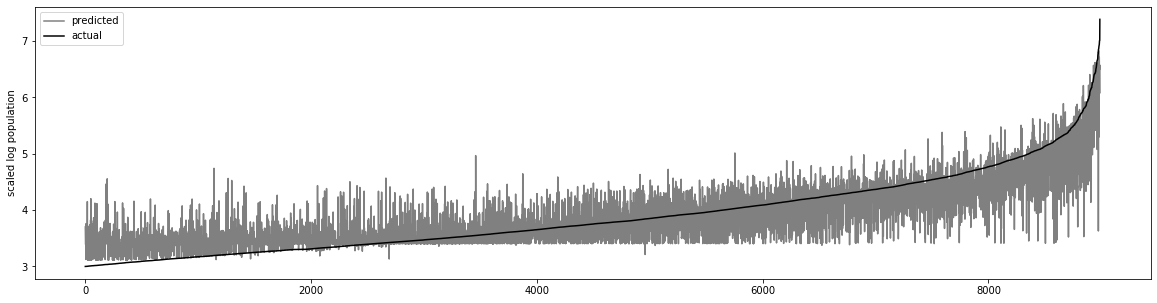

In [8]:
# CELL 8
import bz2
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# read base features
rand = random.Random(42)
all_data = list()
city_to_all_data = dict()
header = None
with open("ch8_cell1_dev_textlen.tsv") as f:
    header = next(f)
    header = header.strip().split("\t")
    header.pop(0) # name
    header.pop() # population
    for line in f:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        city_to_all_data[name] = len(all_data)
        all_data.append( (feats, logpop, name) )
                
# add text features
with open("ch8_cell7_dev_tokens.tsv") as feats:
    extra_header = next(feats)
    extra_header = extra_header.strip().split("\t")
    extra_header.pop(0) # name
    header.extend(extra_header)
    for line in feats:
        fields = line.strip().split("\t")
        name = fields[0]
        all_data[city_to_all_data[name]][0].extend(list(map(float,fields[1:])))
        
with open("ch8_cell8_dev_feat2.tsv", "w") as feats:
    extheader = header.copy()
    extheader.insert(0, 'name')
    extheader.append('logpop')
    feats.write("\t".join(extheader) + "\n")
    for row in all_data:
        feats.write("{}\t{}\t{}\n".format(row[-1], "\t".join(map(str,row[0])), row[1]))
    
# split
train_data = list()
test_data  = list()
for row in all_data:
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)

test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))
train_data = None
test_data  = None

# train
print("Training on {:,} cities".format(len(xtrain)))

rf = RandomForestRegressor(max_features=0.75, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rf.fit(xtrain, ytrain)
ytest_pred = rf.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

xtrain = None
xtest  = None

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest,      label="actual",    color='black')
plt.ylabel('scaled log population')
plt.savefig("ch8_cell8_rf_feat2.pdf", bbox_inches='tight', dpi=300)
plt.legend()

That is an improvement, let us drill down with Error Analysis to see what worked and what did not

I will now proceed to do an Error Analysis looking at the documents that gained the most with the text and the ones that were more hurt (Cel #9)

In [9]:
# CELL 9
import bz2
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from collections import OrderedDict

# read base features
rand = random.Random(42)
base_data         = list()
city_to_base_data = dict()
base_header = None
with open("ch8_cell1_dev_textlen.tsv") as f:
    base_header = next(f)
    base_header = base_header.strip().split("\t")
    base_header.pop(0) # name
    base_header.pop() # population
    for line in f:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        city_to_base_data[name] = len(base_data)
        base_data.append( (feats, logpop, name) )
                
# read text features
mi_data         = list()
city_to_mi_data = dict()
mi_header = None
with open("ch8_cell8_dev_feat2.tsv") as mi:
    mi_header = next(mi)
    mi_header = mi_header.strip().split("\t")
    mi_header.pop(0) # name
    mi_header.pop() # population
    for line in mi:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        city_to_mi_data[name] = len(mi_data)
        mi_data.append( (feats, logpop, name) )

# split
base_train_data = list()
base_test_data  = list()
mi_train_data   = list()
mi_test_data    = list()
for row in base_data:
    if rand.random() < 0.2:
        base_test_data.append(row)
        mi_test_data.append(mi_data[city_to_mi_data[row[-1]]])
    else:
        base_train_data.append(row)
        mi_train_data.append(mi_data[city_to_mi_data[row[-1]]])
base_data = None
mi_data   = None

base_test_data = sorted(base_test_data, key=lambda t:t[1])
mi_test_data   = sorted(mi_test_data,   key=lambda t:t[1])
test_names     = list(map(lambda t:t[2], base_test_data))

base_xtrain = np.array(list(map(lambda t:t[0], base_train_data)))
ytrain      = np.array(list(map(lambda t:t[1], base_train_data)))
base_xtest  = np.array(list(map(lambda t:t[0], base_test_data)))
ytest       = np.array(list(map(lambda t:t[1], base_test_data)))
base_train_data = None
base_test_data  = None

mi_xtrain = np.array(list(map(lambda t:t[0], mi_train_data)))
mi_xtest  = np.array(list(map(lambda t:t[0], mi_test_data)))
mi_train_data = None
mi_test_data  = None

# train
print("Base training on {:,} cities".format(len(ytrain)))

rf = RandomForestRegressor(max_features=0.75, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rf.fit(base_xtrain, ytrain)
base_ytest_pred = rf.predict(base_xtest)
base_se = (base_ytest_pred - ytest)**2

print("M.I. training on {:,} cities".format(len(ytrain)))
rf = RandomForestRegressor(max_features=0.75, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rf.fit(mi_xtrain, ytrain)
mi_ytest_pred = rf.predict(mi_xtest)
mi_se = (mi_ytest_pred - ytest)**2

# find the bigger winners and losers
se_ytest_diff = base_se - mi_se # small is better, it's error
named_se = list()
for idx in range(se_ytest_diff.shape[0]):
    named_se.append( (se_ytest_diff[idx], test_names[idx], idx) )

named_se = sorted(named_se, key=lambda x:x[0], reverse=True)

to_print = OrderedDict()
for idx, winner in enumerate(named_se[:10]):
    to_print[winner[1]] = { 
        'improv' : winner[0], 
        'base'   : int(round(10**base_ytest_pred[winner[2]])),
        'mi'     : int(round(10**mi_ytest_pred[winner[2]])),
        'pop'    : int(round(10**ytest[winner[2]])),
        'type'   : 'winner',
        'pos'    : idx }
for idx, loser in enumerate(named_se[-10:]):
    to_print[loser[1]] = { 
        'improv' : loser[0], 
        'base'   : int(round(10**base_ytest_pred[loser[2]])),
        'mi'     : int(round(10**mi_ytest_pred[loser[2]])),
        'pop'    : int(round(10**ytest[loser[2]])),
        'type'   : 'loser',
        'pos'    : (9-idx)}
    
kept_terms = set(map(lambda l:l.split('\t')[0], open("ch8_cell7_vocab.tsv").readlines()))

base_xtrain = None
base_xtest  = None
mi_xtrain   = None
mi_xtest    = None
                 
htmls = [""] * 20
with bz2.BZ2File("cities1000_wikitext.tsv.bz2","r") as wikitext:
    for byteline in wikitext:
        cityline = byteline.decode("utf-8")
        tab = cityline.index('\t')
        name = cityline[:tab]
        if name in to_print:
            text = cityline[tab:]
            tokens = list(filter(lambda tok: tok in kept_terms, cell7_tokenize(text)))
            text = text.replace('\t','<p>')
            entry = to_print[name]
            this_html = ("<h1>Top {} {}: {}</h1>"+
                     "<h2>Change: {:1.5} (base: {:,}, MI: {:,}). Population: {:,}. Text length: {:,}</h2>{}"+
                     "<h2>Tokens (length {:,})</h2>{}") \
                      .format((entry['pos'] + 1), entry['type'], name[1:-1], entry['improv'], entry['base'], entry['mi'],
                          entry['pop'], len(text), text[:1000], len(tokens), tokens[:100])
            if entry['type'] == 'winner':
                htmls[entry['pos']] = this_html
            else:
                htmls[10+entry['pos']] = this_html
html = "".join(htmls)
from IPython.display import HTML, display
display(HTML(html))

Base training on 35,971 cities
M.I. training on 35,971 cities


Analysis:

<table>
<tr><th>City</th><th>Comments</th></tr>
<tr><td>Bailadores</td><td>'town' does it</td></tr>
<tr><td>Villa Alvarez</td><td>No text</td></tr>
<tr><td>Koro</td><td>'agriculture' most probably is linked to smaller places</td></tr>
<tr><td>Curug</td><td>we got a toknumseg6 for 2010 Census and then the correct toknumseg30, the seg6 does it</td></tr>
<tr><td>Delgado</td><td>no usable terms</td></tr>
<tr><td>Madina</td><td>population of toknumseg30 should be gotten by a stop-words + bigram</td></tr>
<tr><td>Banha</td><td>I think if 'cities' were 'city' it will work</td></tr>
<tr><td>Dunmore</td><td>Small hamlet with  lots of info in Wikipedia, the main signal "village" is not there</td></tr>
<tr><td>Demsa</td><td>the 'population toknumseg30' should do its magic</td></tr>
<tr><td>Xuanwu</td><td>no idea. capital ought to have worked</td></tr>
</table>

census appears in 21,414 cities but it is not picked as a top 1,000, but tons of stop words are, better clean up and also remove variants to see if we can accomodate more


village appears in 13,998 cities but it had a M.I. of 0.0025583964 (compare top M.I. for city of 0.1108237610) and it was at the bottom 100 at position 2881. It should have been selected, but it might be that at 4-way splitting it is not definite enough


conclusion: conflate and filter the terms and/or expand until census and village are added. Look into bigrams, then skip-grams. Let us start with filtering stop-words and doing stemming to include census and village (Cell #8).

## Third Featurization: Morphological features

In some domains, it is useful to reduce the number of features by dropping the morphological variants for different words. For example, if we believe the word _prior_ is useful in our domain, its plural variant _priors_ might be equally useful but more rare. If we conflate both terms as the same feature, we could obtain better performance.

Larger text samples are needed to profit from this approach, though.

To obtain morphological roots for words, we can use a dictionary of root forms (a "lemmatizer" approach) or we can use simple approximation (a "stemmer" approach). 

We will use a stemming approach using an implementation of the Porter stemmer (Cell #10).

### Taboo features (stop words)

A common feature selection technique in natural language processing is to drop a small set of highly frequent function words with little semantic content for classification tasks. This is called "stop word removal", an approach shared with information retrieval. We will use the [snowball list of stopwords](http://snowball.tartarus.org/algorithms/english/stop.txt).

In [10]:
# CELL 10
import re
import pickle
import random
import bz2
import math
import numpy as np
from stemming.porter2 import stem as porter_stem

with open("ch6_cell27_splits.pk", "rb") as pkl:
    segments_at = pickle.load(pkl)

boundaries = list(map(lambda x:( int(round(10**x['min'])), 
                            int(round(10**x['val'])), 
                            int(round(10**x['max'])) ), segments_at[5]))
            
stopwords = set()
with open("stop.txt") as s:
    for line in s:
        if '|' in line:
            line = line[:line.index('|')]
        line = line.strip()
        if len(line) > 0:
            stopwords.add(line)
            
NUM_RE = re.compile('\d?\d?\d?(,?\d{3})+') # at least 3 digits
def cell10_tokenize(text):
    tokens = list(filter(lambda x: len(x)>0 and x not in stopwords,
                         map(lambda x: x.lower(),
                         re.sub('\s+',' ', re.sub('[^A-z,0-9]', ' ', text)).split(' '))))
    result = list()
    for tok in tokens:
        if len(tok) > 1 and tok[-1] == ',':
            tok = tok[:-1]
        if NUM_RE.fullmatch(tok):
            num = int(tok.replace(",",""))
            if num < boundaries[0][0]:
                result.append("TOKNUMSMALL")
            elif num > boundaries[-1][2]:
                result.append("TOKNUMBIG")
            else:
                found = False
                for idx, seg in enumerate(boundaries[1:]):
                    if num < seg[0]:
                        result.append("TOKNUMSEG" + str(idx))
                        found = True
                        break
                if not found:
                    result.append("TOKNUMSEG" + str(len(boundaries) - 1))
        else:
            result.append(porter_stem(tok))
    return result

# read base features
rand = random.Random(42)
city_pop = dict()
with open("ch8_cell1_dev_textlen.tsv") as f:
    header = next(f)
    for line in f:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        city_pop[name] = logpop
cities = sorted(list(city_pop.keys()))
        
# vocabulary
all_vocab     = list()
vocab_to_idx  = dict()
city_tok_idxs = dict()

remaining = set(city_pop.keys())
with bz2.BZ2File("cities1000_wikitext.tsv.bz2","r") as wikitext:
    for byteline in wikitext:
        cityline = byteline.decode("utf-8")
        tab = cityline.index('\t')
        name = cityline[:tab]
        if name in remaining:
            if (len(cities) - len(remaining)) % int(len(cities) / 10) == 0:
                print("Tokenizing {:>5} out of {:>5} cities, city \"{}\""
                      .format((len(cities) - len(remaining)), len(cities), name))
            remaining.remove(name)
            text = cityline[tab:]
            toks = set()
            for token in cell10_tokenize(text):
                idx = vocab_to_idx.get(token, None)
                if idx is None:
                    idx = len(all_vocab)
                    all_vocab.append(token)
                    vocab_to_idx[token] = idx
                toks.add(idx)
            city_tok_idxs[name] = sorted(list(toks))

for name in remaining:
    city_tok_idxs[name] = list()
    
print("Total vocabulary: {:,}".format(len(all_vocab)))

# drop tokens that appear in less that 200 documents
tok_docs = list()
for _ in range(len(all_vocab)):
    tok_docs.append([])
for doc_idx, name in enumerate(cities):
    tok_idxs = city_tok_idxs[name]
    for tok_idx in tok_idxs:
        tok_docs[tok_idx].append(doc_idx)
city_tok_idxs = None

threshold = 200
reduced_vocab = list()
for tok_idx in range(len(all_vocab)):
    if len(tok_docs[tok_idx]) >= threshold:
        reduced_vocab.append(tok_idx)
        
print("Reduced vocabulary: {:,} (reduction {:%})"
      .format(len(reduced_vocab), (len(all_vocab) - len(reduced_vocab)) / len(all_vocab)))    

ydata = np.array(list(map(lambda c:city_pop[c], cities)))

# use more classes here to see if we can pick 'village'
ydata = cell7_adjudicate(ydata, segments_at[4])

feature_utility = list()

xdata = np.zeros( ydata.shape )
for pos, tok_idx in enumerate(reduced_vocab):
    verbose = False
    if pos % int(len(reduced_vocab) / 100) == 0:
        print("Computing M.I. for {:>6} out of {:>6} tokens, token \"{}\""
              .format(pos, len(reduced_vocab), all_vocab[tok_idx]))
        #verbose = True

    xdata[:] = 0
    for idx in tok_docs[tok_idx]:
        xdata[idx] = 1.0

    # compute confusion table
    table = dict()
    for row in range(xdata.shape[0]):
        feat_val = int(xdata[row])
        target_val = int(ydata[row])
        if feat_val not in table:
            table[feat_val] = dict()
        table[feat_val][target_val] = table[feat_val].get(target_val, 0) + 1

    feats = set()
    for row in table.values():
        feats.update(row.keys())
    cols = { val: sum(map(lambda x:x.get(val,0), table.values())) for val in feats }
    full_table = sum(cols.values())
    
    if verbose:
        print("\tTable:\n\t{}\n\tfull_table: {}\n\tCols: {}"
              .format(table, full_table, cols))
    
    best_utility = None
    for feat_val in table.keys():
        for target_val in table[feat_val].keys():
            # binarize
            n11 = table[feat_val][target_val]
            if n11 < 5:
                if verbose:
                    print("\tFor feat_val={}, target_val={}, n11={}, skipping"
                        .format(feat_val, target_val, n11))
                continue
            n10 = sum(table[feat_val].values()) - n11
            n01 = cols.get(target_val) - n11
            n00 = full_table - n11 - n10 - n01
            if n10 == 0 or n01 == 0 or n00 == 0:
                if verbose:
                    print("\tFor feat_val={}, target_val={}, n10={} or n01={} or n00={} is zero, skipping"
                        .format(feat_val, target_val, n10, n01, n00))
                continue
            n1_ = n11 + n10
            n0_ = n01 + n00
            n_1 = n11 + n01
            n_0 = n10 + n00
            n = float(full_table)
            utility = n11/n * math.log(n*n11/(n1_*n_1),2) + \
               n01 / n * math.log(n*n01/(n0_*n_1), 2) + \
               n10 / n * math.log(n*n10/(n1_*n_0), 2) + \
               n00 / n * math.log(n*n00/(n0_*n_0), 2)
            if best_utility is None or best_utility < utility:
                best_utility = utility
    if verbose:
        print("\tbest_utility: {}".format(best_utility))
    if best_utility is not None:
        feature_utility.append( (all_vocab[tok_idx], best_utility) )
all_vocab = None # free memory
    
feature_utility = sorted(feature_utility, key=lambda x:x[1], reverse=True)

PARAM_KEEP_TOP = 1000
with open("ch8_cell10_vocab.tsv", "w") as kept:
    for row in feature_utility[:PARAM_KEEP_TOP]:
        kept.write("{}\t{}\n".format(*row))
        
table1 = ("<table><tr><th>Position</th><th>Stem</th><th>Utility</th></tr>" +
            "\n".join(list(map(lambda r: 
                               "<tr><td>{}</td><td>{}</td><td>{:5.10f}</td></tr>".format(
                        r[0], r[1][0], r[1][1]), 
                               enumerate(feature_utility[:100])))) +"</table>")
table2 = ("<table><tr><th>Position</th><th>Stem</th><th>Utility</th></tr>" +
            "\n".join(list(map(lambda r: 
                               "<tr><td>{}</td><td>{}</td><td>{:5.10f}</td></tr>".format(
                        r[0], r[1][0], r[1][1]), 
                               enumerate(reversed(feature_utility[-100:]))))) +"</table>")

with open("ch8_cell10_dev_tokens.tsv", "w") as kept:
    kept.write("name\t" + "\t".join(map(lambda x:"token=" + x[0],feature_utility[:PARAM_KEEP_TOP]))+"\n")
    matrix = np.zeros( (ydata.shape[0], PARAM_KEEP_TOP) )
    for idx_tok, row in enumerate(feature_utility[:PARAM_KEEP_TOP]):
        tok = row[0]
        for idx_doc in tok_docs[vocab_to_idx[tok]]:
            matrix[idx_doc, idx_tok] = 1.0
    for idx_doc in range(matrix.shape[0]):
        kept.write(cities[idx_doc] + "\t" + "\t".join(map(str,matrix[idx_doc,:])) +"\n")
matrix       = None
tok_docs     = None
vocab_to_idx = None

from IPython.display import HTML, display
display(HTML("<h3>Top 100 tokens by MI</h3>" + table1 + 
             "<h3>Last 100 tokens by MI</h3>" + table2))

Tokenizing     0 out of 44959 cities, city "<http://dbpedia.org/resource/Ankara>"
Tokenizing  4495 out of 44959 cities, city "<http://dbpedia.org/resource/Gonzales,_Louisiana>"
Tokenizing  8990 out of 44959 cities, city "<http://dbpedia.org/resource/Laurel_Bay,_South_Carolina>"
Tokenizing 13485 out of 44959 cities, city "<http://dbpedia.org/resource/Nysa,_Poland>"
Tokenizing 17980 out of 44959 cities, city "<http://dbpedia.org/resource/Vilathikulam>"
Tokenizing 22475 out of 44959 cities, city "<http://dbpedia.org/resource/Arroyo_Seco,_Santa_Fe>"
Tokenizing 26970 out of 44959 cities, city "<http://dbpedia.org/resource/Fatehpur,_Barabanki>"
Tokenizing 31465 out of 44959 cities, city "<http://dbpedia.org/resource/Kirchheim_am_Neckar>"
Tokenizing 35960 out of 44959 cities, city "<http://dbpedia.org/resource/Pirching_am_Traubenberg>"
Tokenizing 40455 out of 44959 cities, city "<http://dbpedia.org/resource/Scone,_Perth_and_Kinross>"
Tokenizing 44950 out of 44959 cities, city "<http://dbpedia

Position,Stem,Utility
0,TOKNUMSEG30,0.0537331244
1,citi,0.0513839709
2,capit,0.0482481137
3,airport,0.0445746900
4,temperatur,0.0420718228
5,climat,0.0420551462
6,univers,0.0404202701
7,intern,0.0398616893
8,TOKNUMSEG29,0.0371992907
9,urban,0.0370085142


Tokenization now takes much more time. It is the reason that NLP is usually done in batch using multiple machines, using frameworks such as Apache UIMA [LINK] or Spark NLP. Adding NER will make it much more slow.

Also, as I add more complexity, the results are more difficult to understand (what type of tokens the stem 'civil' captures? 'civilization'? 'civilized'? intriguing.)

'village' is still not picked (top 1647). (Expanding to 2000 terms was tried but didn't help).

I'll now re-do training the training in Cell #11.

Training on 35,971 cities
RMSE 0.3267168745861243


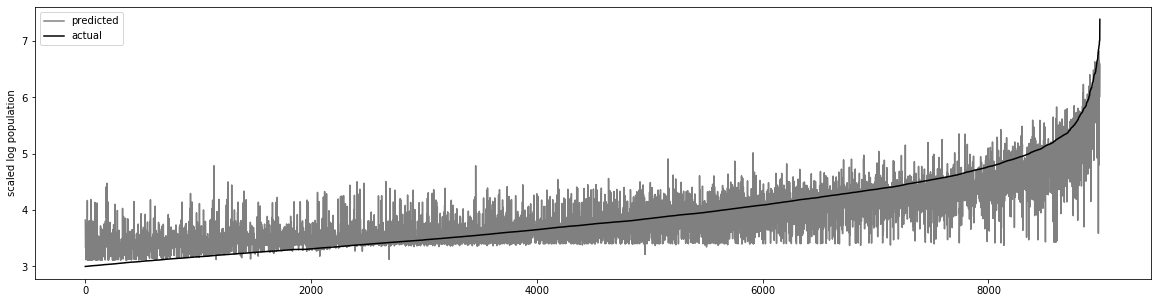

In [11]:
# CELL 11
import bz2
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# read base features
rand = random.Random(42)
all_data = list()
city_to_all_data = dict()
header = None
with open("ch8_cell1_dev_textlen.tsv") as f:
    header = next(f)
    header = header.strip().split("\t")
    header.pop(0) # name
    header.pop() # population
    for line in f:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        city_to_all_data[name] = len(all_data)
        all_data.append( (feats, logpop, name) )
                
# add text features
with open("ch8_cell10_dev_tokens.tsv") as feats:
    extra_header = next(feats)
    extra_header = extra_header.strip().split("\t")
    extra_header.pop(0) # name
    header.extend(extra_header)
    for line in feats:
        fields = line.strip().split("\t")
        name = fields[0]
        all_data[city_to_all_data[name]][0].extend(list(map(float,fields[1:])))
        
with open("ch8_cell11_dev_feat3.tsv", "w") as feats:
    extheader = header.copy()
    extheader.insert(0, 'name')
    extheader.append('logpop')
    feats.write("\t".join(extheader) + "\n")
    for row in all_data:
        feats.write("{}\t{}\t{}\n".format(row[-1], "\t".join(map(str,row[0])), row[1]))
    
# split
train_data = list()
test_data  = list()
for row in all_data:
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)

test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))
train_data = None
test_data  = None

# train
print("Training on {:,} cities".format(len(xtrain)))

rf = RandomForestRegressor(max_features=0.75, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rf.fit(xtrain, ytrain)
ytest_pred = rf.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

xtrain = None
xtest  = None

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest,      label="actual",    color='black')
plt.ylabel('scaled log population')
plt.savefig("ch8_cell11_rf_feat3.pdf", bbox_inches='tight', dpi=300)
plt.legend()

At RMSE 0.3267, we're getting closer to the best performance of Chapter 6.

And now for the error analysis as before (Cell #12).

In [12]:
# CELL 12
import bz2
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# read base features
rand = random.Random(42)
base_data         = list()
city_to_base_data = dict()
base_header = None
with open("ch8_cell1_dev_textlen.tsv") as f:
    base_header = next(f)
    base_header = base_header.strip().split("\t")
    base_header.pop(0) # name
    base_header.pop() # population
    for line in f:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        city_to_base_data[name] = len(base_data)
        base_data.append( (feats, logpop, name) )
                
# read text features
mi_data         = list()
city_to_mi_data = dict()
mi_header = None
with open("ch8_cell11_dev_feat3.tsv") as mi:
    mi_header = next(mi)
    mi_header = mi_header.strip().split("\t")
    mi_header.pop(0) # name
    mi_header.pop() # population
    for line in mi:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        city_to_mi_data[name] = len(mi_data)
        mi_data.append( (feats, logpop, name) )
        
# split
base_train_data = list()
base_test_data  = list()
mi_train_data   = list()
mi_test_data    = list()
for row in base_data:
    if rand.random() < 0.2:
        base_test_data.append(row)
        mi_test_data.append(mi_data[city_to_mi_data[row[-1]]])
    else:
        base_train_data.append(row)
        mi_train_data.append(mi_data[city_to_mi_data[row[-1]]])
base_data = None
mi_data   = None

base_test_data = sorted(base_test_data, key=lambda t:t[1])
mi_test_data   = sorted(mi_test_data, key=lambda t:t[1])
test_names     = list(map(lambda t:t[2], base_test_data))

base_xtrain = np.array(list(map(lambda t:t[0], base_train_data)))
ytrain      = np.array(list(map(lambda t:t[1], base_train_data)))
base_xtest  = np.array(list(map(lambda t:t[0], base_test_data)))
ytest       = np.array(list(map(lambda t:t[1], base_test_data)))
base_train_data = None
base_test_data  = None


mi_xtrain = np.array(list(map(lambda t:t[0], mi_train_data)))
mi_xtest  = np.array(list(map(lambda t:t[0], mi_test_data)))
mi_train_data = None
mi_test_data  = None

# train
print("Base training on {:,} cities".format(len(base_xtrain)))

rf = RandomForestRegressor(max_features=0.75, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rf.fit(base_xtrain, ytrain)
base_ytest_pred = rf.predict(base_xtest)
base_se = (base_ytest_pred - ytest)**2

print("M.I. training on {:,} cities".format(len(mi_xtrain)))
rf = RandomForestRegressor(max_features=0.75, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rf.fit(mi_xtrain, ytrain)
mi_ytest_pred = rf.predict(mi_xtest)
mi_se = (mi_ytest_pred - ytest)**2

# find the bigger winners and losers
se_ytest_diff = base_se - mi_se # small is better, it's error
named_se = list()
for idx in range(se_ytest_diff.shape[0]):
    named_se.append( (se_ytest_diff[idx], test_names[idx], idx) )

named_se = sorted(named_se, key=lambda x:x[0], reverse=True)

to_print = dict()
for idx, winner in enumerate(named_se[:10]):
    to_print[winner[1]] = { 
        'improv' : winner[0], 
        'base': int(round(10**base_ytest_pred[winner[2]])),
        'mi': int(round(10**mi_ytest_pred[winner[2]])),
        'pop': int(round(10**ytest[winner[2]])),
        'type': 'winner',
        'pos': idx }
for idx, loser in enumerate(named_se[-10:]):
    to_print[loser[1]] = { 
        'improv' : loser[0], 
        'base': int(round(10**base_ytest_pred[loser[2]])),
        'mi': int(round(10**mi_ytest_pred[loser[2]])),
        'pop': int(round(10**ytest[loser[2]])),
        'type': 'loser',
        'pos': (9-idx)}
    
kept_terms = set(map(lambda l:l.split('\t')[0], open("ch8_cell10_vocab.tsv").readlines()))

base_xtrain = None
base_xtest  = None
mi_xtrain   = None
mi_xtest    = None
                 
htmls = [""] * 20
with bz2.BZ2File("cities1000_wikitext.tsv.bz2","r") as wikitext:
    for byteline in wikitext:
        cityline = byteline.decode("utf-8")
        tab = cityline.index('\t')
        name = cityline[:tab]
        if name in to_print:
            text = cityline[tab:]
            tokens = list(filter(lambda tok: tok in kept_terms, cell10_tokenize(text)))
            text = text.replace('\t','<p>')
            entry = to_print[name]
            this_html = ("<h1>Top {} {}: {}</h1>"+
                     "<h2>Change: {:1.5} (base: {:,}, MI: {:,}). Population: {:,}. Text length: {:,}</h2>{}"+
                     "<h2>Tokens (length {:,})</h2>{}") \
                      .format((entry['pos'] + 1), entry['type'], name[1:-1], entry['improv'], entry['base'], 
                              entry['mi'], entry['pop'], len(text), text[:1000], len(tokens), tokens[:100])
            if entry['type'] == 'winner':
                htmls[entry['pos']] = this_html
            else:
                htmls[10+entry['pos']] = this_html
html = "".join(htmls)
from IPython.display import HTML, display
display(HTML(html))

Base training on 35,971 cities
M.I. training on 35,971 cities


We can see some new winners and losers but many repeats. Now, on the sequence of tokens we see thinks like 'popul' 'toknumseg30' that ought to inform about the overall size, if the ML were made aware this words are contiguous, which bring us to the concept of bigrams and the fourth featurization.

## Fourth Featurization: Words in context

To incorporate some ordering among the words, a common technique is to use bigrams, pairs of words in order. If we were ot use bigrams directly, this will increase the vocabulary size quite a bit, so I'll threshold their minimum occurrence (Cell #13).

Tokenizing+bigrams     0 out of 44959 cities, bigrams 0 city "<http://dbpedia.org/resource/Ankara>"
Tokenizing+bigrams  4495 out of 44959 cities, bigrams 335,865 city "<http://dbpedia.org/resource/Gonzales,_Louisiana>"
Tokenizing+bigrams  8990 out of 44959 cities, bigrams 382,256 city "<http://dbpedia.org/resource/Laurel_Bay,_South_Carolina>"
Tokenizing+bigrams 13485 out of 44959 cities, bigrams 458,421 city "<http://dbpedia.org/resource/Nysa,_Poland>"
Tokenizing+bigrams 17980 out of 44959 cities, bigrams 512,669 city "<http://dbpedia.org/resource/Vilathikulam>"
Tokenizing+bigrams 22475 out of 44959 cities, bigrams 540,316 city "<http://dbpedia.org/resource/Arroyo_Seco,_Santa_Fe>"
Tokenizing+bigrams 26970 out of 44959 cities, bigrams 557,120 city "<http://dbpedia.org/resource/Fatehpur,_Barabanki>"
Tokenizing+bigrams 31465 out of 44959 cities, bigrams 566,614 city "<http://dbpedia.org/resource/Kirchheim_am_Neckar>"
Tokenizing+bigrams 35960 out of 44959 cities, bigrams 571,918 city "<htt

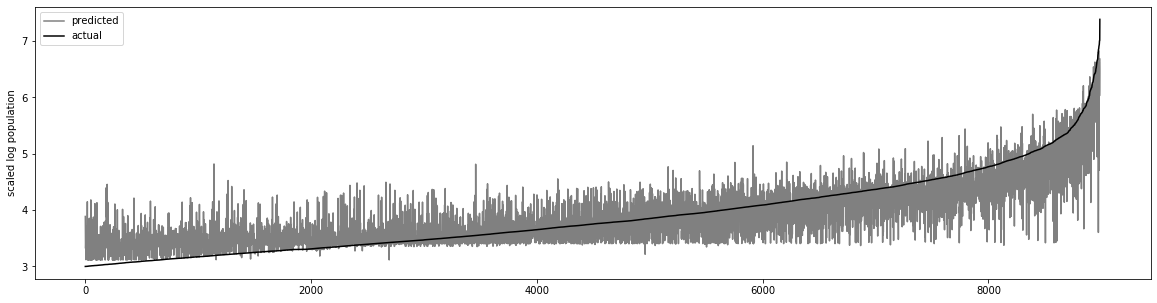

In [13]:
# CELL 13
import bz2
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# read text features
rand = random.Random(42)
all_data = list()
city_to_all_data = dict()
header = None
with open("ch8_cell11_dev_feat3.tsv") as mi:
    header = next(mi)
    header = header.strip().split("\t")
    header.pop(0) # name
    header.pop() # population
    for line in mi:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        city_to_all_data[name] = len(all_data)
        all_data.append( (feats, logpop, name) )
cities = sorted(list(city_to_all_data.keys()))

kept_terms = set(map(lambda l:l.split('\t')[0], open("ch8_cell10_vocab.tsv").readlines()))

remaining = set(cities)
all_bigrams = list()
bigram_to_idx    = dict()
city_bigram_idxs = dict()
with bz2.BZ2File("cities1000_wikitext.tsv.bz2","r") as wikitext:
    for byteline in wikitext:
        cityline = byteline.decode("utf-8")
        tab = cityline.index('\t')
        name = cityline[:tab]
        if name in remaining:
            if (len(cities) - len(remaining)) % int(len(cities) / 10) == 0:
                print("Tokenizing+bigrams {:>5} out of {:>5} cities, bigrams {:,} city \"{}\""
                      .format((len(cities) - len(remaining)), len(cities), len(all_bigrams), name))
            remaining.remove(name)
            text = cityline[tab:]
            bigrams = set()
            prev = '[PAD]'
            for token in list(filter(lambda tok: tok in kept_terms, cell10_tokenize(text))):
                bigram = prev + '-' + token
                prev = token
                idx = bigram_to_idx.get(bigram, None)
                if idx is None:
                    idx = len(all_bigrams)
                    all_bigrams.append(bigram)
                    bigram_to_idx[bigram] = idx
                bigrams.add(idx)
            city_bigram_idxs[name] = sorted(list(toks))
bigram_to_idx = None

for name in remaining:
    city_bigram_idxs[name] = list()

print("Total bigrams: {:,}".format(len(all_bigrams)))

# drop bigrams that appear in less that 50 documents
bigram_docs = list()
for _ in range(len(all_bigrams)):
    bigram_docs.append([])
for doc_idx, name in enumerate(cities):
    bigram_idxs = city_bigram_idxs[name]
    for bigram_idx in bigram_idxs:
        bigram_docs[bigram_idx].append(doc_idx)
city_bigram_idxs = None

threshold = 50
reduced_bigrams = list()
for bigram_idx in range(len(all_bigrams)):
    if len(bigram_docs[bigram_idx]) >= threshold:
        reduced_bigrams.append(bigram_idx)
        
print("Reduced bigrams: {:,} (reduction {:%})"
      .format(len(reduced_bigrams), (len(all_bigrams) - len(reduced_bigrams)) / len(all_bigrams)))    

matrix = np.zeros( (len(cities), len(reduced_bigrams)) )
for idx, bigram_idx in enumerate(reduced_bigrams):
    header.append("bigram=" + all_bigrams[bigram_idx])

    for idx_doc in bigram_docs[bigram_idx]:
        matrix[idx_doc, idx] = 1.0

for idx_doc in range(len(cities)):
    all_data[city_to_all_data[cities[idx_doc]]][0].extend(matrix[idx_doc,:])
bigram_docs = None
matrix      = None 

with open("ch8_cell13_dev_feat4.tsv", "w") as f:
    f.write("name\t" + "\t".join(header)+"\tlogpop\n")
    for idx_doc in range(len(cities)):
        name = cities[idx_doc]
        entry = all_data[city_to_all_data[name]]
        f.write("{}\t{}\t{}\n".format(name, "\t".join(map(str,entry[0])), entry[1]))

# split
train_data = list()
test_data  = list()
for row in all_data:
    if rand.random() < 0.2:
        test_data.append(row)
    else:
        train_data.append(row)
all_data = None # free memory

test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))
train_data = None
test_data  = None

# train
print("Training on {:,} cities".format(len(xtrain)))

rf = RandomForestRegressor(max_features=0.75, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rf.fit(xtrain, ytrain)
ytest_pred = rf.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

# free memory
all_bigrams = None
xtrain      = None
xtest       = None


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest,      label="actual",    color='black')
plt.ylabel('scaled log population')
plt.savefig("ch8_cell13_rf_feat4.pdf", bbox_inches='tight', dpi=300)
plt.legend()

That did worse. But what we were trying to accomplish (populatio-number) is not among the picked bigrams for any of the population numbers. Let's try skip-bigrams with hash encoding instead.

## Fifth Featurization: Skip-bigrams

I will combine skip-bigrams with feature hashing to reduce the number of bigrams to a manageable size (Cell #14).

For hashing function, we will use Python's buit-in hashing function

Tokenizing+skip-bigrams     0 out of 44959 cities, city "<http://dbpedia.org/resource/Ankara>"
Tokenizing+skip-bigrams  4495 out of 44959 cities, city "<http://dbpedia.org/resource/Gonzales,_Louisiana>"
Tokenizing+skip-bigrams  8990 out of 44959 cities, city "<http://dbpedia.org/resource/Laurel_Bay,_South_Carolina>"
Tokenizing+skip-bigrams 13485 out of 44959 cities, city "<http://dbpedia.org/resource/Nysa,_Poland>"
Tokenizing+skip-bigrams 17980 out of 44959 cities, city "<http://dbpedia.org/resource/Vilathikulam>"
Tokenizing+skip-bigrams 22475 out of 44959 cities, city "<http://dbpedia.org/resource/Arroyo_Seco,_Santa_Fe>"
Tokenizing+skip-bigrams 26970 out of 44959 cities, city "<http://dbpedia.org/resource/Fatehpur,_Barabanki>"
Tokenizing+skip-bigrams 31465 out of 44959 cities, city "<http://dbpedia.org/resource/Kirchheim_am_Neckar>"
Tokenizing+skip-bigrams 35960 out of 44959 cities, city "<http://dbpedia.org/resource/Pirching_am_Traubenberg>"
Tokenizing+skip-bigrams 40455 out of 44959

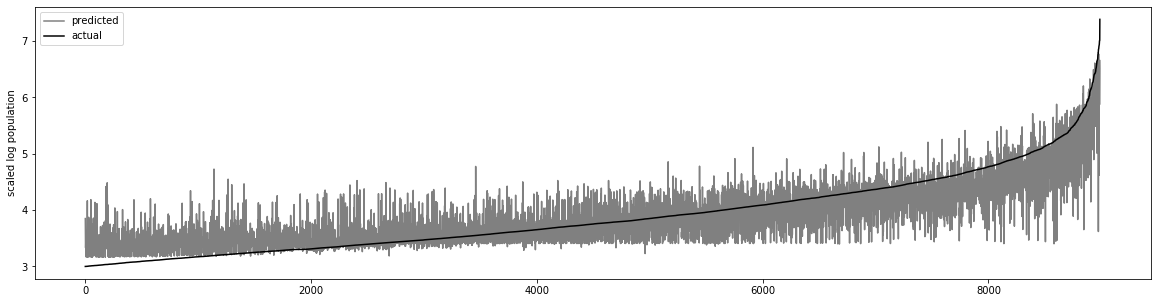

In [14]:
# CELL 14
import bz2
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np

PARAM_HASH_SIZE=3000
PARAM_SKIP_SIZE=6
PARAM_STABLE_HASHES=True

def cell14_hash(x):
    hashed = 0
    if PARAM_STABLE_HASHES:
        # pure python FNV1a
        if x:
            hashed = 14695981039346656037
            for c in x:
                hashed = hashed ^ ord(c)
                hashed = (hashed * 1099511628211)
    else:
        # python after 3.3 use siphash24, which is better and the C implementation 
        # is faster but it is salted so unless you have to set PYTHONSEED environment 
        # variable to 0 (a bad idea) otherwise every run will produce different hashes
        hashed = hash(x)
    return abs(hashed) % PARAM_HASH_SIZE 
    
# read text features
rand   = random.Random(42)
all_data         = list()
city_to_all_data = dict()
header = None
with open("ch8_cell11_dev_feat3.tsv") as mi:
    header = next(mi)
    header = header.strip().split("\t")
    header.pop(0) # name
    header.pop() # population
    for line in mi:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name  = fields[0]
        feats = list(map(float,fields[1:-1]))
        city_to_all_data[name] = len(all_data)
        all_data.append( (feats, logpop, name) )
cities = sorted(list(city_to_all_data.keys()))

kept_terms = set(map(lambda l:l.split('\t')[0], open("ch8_cell10_vocab.tsv").readlines()))

remaining = set(cities)
with bz2.BZ2File("cities1000_wikitext.tsv.bz2","r") as wikitext:
    for byteline in wikitext:
        cityline = byteline.decode("utf-8")
        tab = cityline.index('\t')
        name = cityline[:tab]
        if name in remaining:
            if (len(cities) - len(remaining)) % int(len(cities) / 10) == 0:
                print("Tokenizing+skip-bigrams {:>5} out of {:>5} cities, city \"{}\""
                      .format((len(cities) - len(remaining)), len(cities), name))
            remaining.remove(name)
            text    = cityline[tab:]
            bigrams = set()
            prev = [ '[PAD]' ] * PARAM_SKIP_SIZE
            feats = [ 0.0 ] * PARAM_HASH_SIZE
            for token in list(filter(lambda tok: tok in kept_terms, cell10_tokenize(text))):
                for skip in prev:
                    bigram = skip + '-' + token
                    feats[cell14_hash(bigram)] = 1.0
                prev.pop(0)
                prev.append(token)
            all_data[city_to_all_data[name]][0].extend(feats)

for name in remaining:
    all_data[city_to_all_data[name]][0].extend([ 0.0 ] * PARAM_HASH_SIZE)

for idx in range(PARAM_HASH_SIZE):
    header.append("hashed_skip_bigram#" + str(idx))

with open("ch8_cell14_dev_feat5.tsv", "w") as f:
    f.write("name\t" + "\t".join(header)+"\tlogpop\n")
    for idx_doc in range(len(cities)):
        name = cities[idx_doc]
        entry = all_data[city_to_all_data[name]]
        f.write("{}\t{}\t{}\n".format(name, "\t".join(map(str,entry[0])), entry[1]))

# split
train_data = list()
test_data  = list()
for row in all_data:
    if rand.random() < 0.2:
        test_data.append(row)
    else:
        train_data.append(row)
all_data = None # free memory

test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))
train_data = None
test_data  = None

# train
print("Training on {:,} cities".format(len(xtrain)))

rf = RandomForestRegressor(max_features=0.75, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rf.fit(xtrain, ytrain)
ytest_pred = rf.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

xtrain = None
xtest  = None

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch8_cell14_rf_feat5.pdf", bbox_inches='tight', dpi=300)
plt.legend()

## Sixth Featurization: Embeddings

Finally, we explore using word embeddings (Cell #15). Because the embeddings and TF\*IDF scores might overfit, I'll compute them on the trainset only.

To use these embeddings, we take the weighted average embedding for the whole document. We can also take the maximum and minimum for each coordinate, over all entries in the document.


### TF\*IDF

Instead of using raw counts, we can perform a traditional feature weighting employed in NLP/IR: adjust the counts by the inverse of the frequency of the word type over the corpus.

Therefore, we replace the Term Frequency (term is synonym with word type in IR) in the document with the TF times the Inverse Document Frequency (IDF). To have more informed statistics, we can compute the IDF counts on a larger set (e.g., Wikipedia or in our case, the whole StackOverflow dump). In this example we will use the train set.

Tokenizing     0 out of 44959 cities, city "<http://dbpedia.org/resource/Ankara>"
Tokenizing  4495 out of 44959 cities, city "<http://dbpedia.org/resource/Gonzales,_Louisiana>"
Tokenizing  8990 out of 44959 cities, city "<http://dbpedia.org/resource/Laurel_Bay,_South_Carolina>"
Tokenizing 13485 out of 44959 cities, city "<http://dbpedia.org/resource/Nysa,_Poland>"
Tokenizing 17980 out of 44959 cities, city "<http://dbpedia.org/resource/Vilathikulam>"
Tokenizing 22475 out of 44959 cities, city "<http://dbpedia.org/resource/Arroyo_Seco,_Santa_Fe>"
Tokenizing 26970 out of 44959 cities, city "<http://dbpedia.org/resource/Fatehpur,_Barabanki>"
Tokenizing 31465 out of 44959 cities, city "<http://dbpedia.org/resource/Kirchheim_am_Neckar>"
Tokenizing 35960 out of 44959 cities, city "<http://dbpedia.org/resource/Pirching_am_Traubenberg>"
Tokenizing 40455 out of 44959 cities, city "<http://dbpedia.org/resource/Scone,_Perth_and_Kinross>"
Tokenizing 44950 out of 44959 cities, city "<http://dbpedia

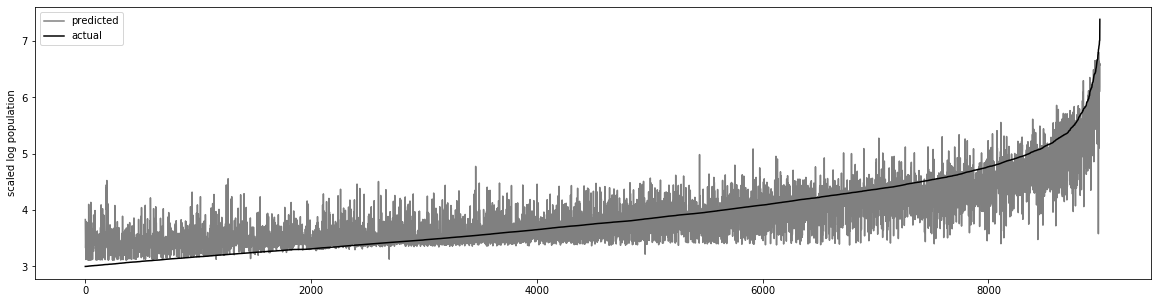

In [15]:
# CELL 15
import re
import pickle
import random
import bz2
import math
from collections import OrderedDict

import numpy as np
import gensim
from sklearn.ensemble import RandomForestRegressor
from stemming.porter2 import stem as porter_stem

with open("ch6_cell27_splits.pk", "rb") as pkl:
    segments_at = pickle.load(pkl)

boundaries = list(map(lambda x:( int(round(10**x['min'])), 
                            int(round(10**x['val'])), 
                            int(round(10**x['max'])) ), segments_at[5]))
NUM_RE = re.compile('\d?\d?\d?(,?\d{3})+') # at least 3 digits
def cell15_tokenize(text):
    tokens = list(filter(lambda x: len(x)>0,
                         map(lambda x: x.lower(),
                         re.sub('\s+',' ', re.sub('[^A-z,0-9]', ' ', text)).split(' '))))
    result = list()
    for tok in tokens:
        if len(tok) > 1 and tok[-1] == ',':
            tok = tok[:-1]
        if NUM_RE.fullmatch(tok):
            num = int(tok.replace(",",""))
            if num < boundaries[0][0]:
                result.append("TOKNUMSMALL")
            elif num > boundaries[-1][2]:
                result.append("TOKNUMBIG")
            else:
                found = False
                for idx, seg in enumerate(boundaries[1:]):
                    if num < seg[0]:
                        result.append("TOKNUMSEG" + str(idx))
                        found = True
                        break
                if not found:
                    result.append("TOKNUMSEG" + str(len(boundaries) - 1))
        else:
            result.append(porter_stem(tok))
    return result

# read text features
rand = random.Random(42)
all_data         = list()
city_to_all_data = dict()
header = None
with open("ch8_cell11_dev_feat3.tsv") as mi:
    header = next(mi)
    header = header.strip().split("\t")
    header.pop(0) # name
    header.pop() # population
    for line in mi:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name  = fields[0]
        feats = list(map(float,fields[1:-1]))
        city_to_all_data[name] = len(all_data)
        all_data.append( (feats, logpop, name) )
cities = sorted(list(city_to_all_data.keys()))

# tokenize documents
city_tokenized = OrderedDict()
PARAM_COMPUTE_NEW_TOKENS = True
if PARAM_COMPUTE_NEW_TOKENS:
    remaining = set(city_to_all_data.keys())
    with bz2.BZ2File("cities1000_wikitext.tsv.bz2","r") as wikitext:
        for byteline in wikitext:
            cityline = byteline.decode("utf-8")
            tab      = cityline.index('\t')
            name     = cityline[:tab]
            if name in remaining:
                if (len(cities) - len(remaining)) % int(len(cities) / 10) == 0:
                    print("Tokenizing {:>5} out of {:>5} cities, city \"{}\""
                          .format((len(cities) - len(remaining)), len(cities), name))
                remaining.remove(name)
                text = cityline[tab:]
                city_tokenized[name] = cell15_tokenize(text)

    for name in remaining:
        city_tokenized[name] = list()

    print("Saving tokens...")
    with open("ch8_cell15_tokens.txt", "w") as f:
        for city, tokens in city_tokenized.items():
            f.write("{}\t{}\n".format(city, " ".join(tokens)))
else:
    print("Reading tokens...")
    with open("ch8_cell15_tokens.txt", "r") as f:
        for line in f:
            (city, toks) = line.split("\t")
            city_tokenized[city] = toks.split(" ")    
    
# split
train_data = list()
test_data  = list()
for row in all_data:
    if rand.random() < 0.2:
        test_data.append(row)
    else:
        train_data.append(row)
all_data = None # free memory

train_cities         = list(map(lambda x:x[-1], train_data))
tokenized_train_docs = list(map(lambda city:city_tokenized[city], train_cities))
print("Saving train split...")
with open("ch8_cell15_train_cities.txt", "w") as f:
    for city in city_tokenized.keys():
        f.write("{}\n".format(city))

PARAM_EMBEDDING_SIZE = 50
print("Training embeddings of size {}".format(PARAM_EMBEDDING_SIZE))
model   = gensim.models.Word2Vec(tokenized_train_docs, size=PARAM_EMBEDDING_SIZE)
tok2vec = dict(zip(model.wv.index2word, model.wv.vectors))

print("Trained ", len(tok2vec), " embeddings")
print("Saving embeddings...")
with open("ch8_cell15_embeddings.tsv", "w") as f:
    for token in model.wv.vocab.keys():
        f.write("{}\t{}\n".format(token, "\t".join(map(str,model.wv[token]))))

# compute idfs
df_tok = OrderedDict()
for tok_doc in tokenized_train_docs:
    seen = set()
    for tok in tok_doc:
        if tok not in seen:
            df_tok[tok] = df_tok.get(tok, 0) + 1
            seen.add(tok)
idf_tok = OrderedDict()    
for tok in df_tok:
    idf_tok[tok] = math.log(1 + len(tokenized_train_docs) * 1.0 / df_tok[tok])
print("Computed {:,} IDFs".format(len(idf_tok)))
print("Saving idfs...")
with open("ch8_cell15_idfs.tsv", "w") as f:
    for tok, idf in idf_tok.items():
        f.write("{}\t{}\n".format(tok, idf))

# plot
PARAM_PLOT_TSNE = True
if PARAM_PLOT_TSNE:
    print("Computing t-SNE...")
    from sklearn.manifold import TSNE
    vectors = []
    words = list(model.wv.vocab.keys())
    rand.shuffle(words)
    for word in words:
        vectors.append(model.wv[word])
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=500, random_state=23)
    projected = tsne_model.fit_transform(vectors)

    x = []
    y = []
    for t in projected:
        x.append(t[0])
        y.append(t[1])

    print("Saving t-SNE points...")
    with open("ch8_cell15_tsne.tsv", "w") as embed:
        for idx in range(len(words)):
            embed.write("{}\t{}\t{}\n".format(words[idx], x[idx], y[idx]))
            
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()
    plt.rcParams['figure.figsize'] = [20, 20]
    plotted_count   = 0
    plotted_section = set()
    # plot a meaningful, visible sample
    for idx in range(len(x)):
        if df_tok[words[idx]] < 200:
            continue # ensure meaningful
        section = str(int(x[idx] * 10 * 4)) + "-" + str(int(y[idx] * 10 * 4))
        if section in plotted_section:
            continue # ensure visible
        plotted_section.add(section)
        plotted_count += 1
        plt.scatter(x[idx] ,y[idx])
        plt.annotate(words[idx], xy=(x[idx], y[idx]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom')
        if plotted_count > 150:
            break # ensure visible

    plt.savefig("ch8_cell15_tsne.pdf", bbox_inches='tight', dpi=300)

# encode train_data and test_data
def encode(toks):
    result = np.zeros( (PARAM_EMBEDDING_SIZE,) )
    good_toks = list(filter(lambda t:t in tok2vec, toks))
    for tok in good_toks:
        tok_vect_scaled = np.copy(tok2vec[tok])
        tok_vect_scaled *= idf_tok[tok] / len(good_toks)
        result += tok_vect_scaled
    return result

for data in (train_data, test_data):
    for row in data:
        name = row[-1]
        row[0].extend(encode(city_tokenized[name]))

test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))
train_data     = None
test_data      = None
idf_tok        = None
df_tok         = None
tok2vec        = None
city_tokenized = None
# train
print("Training on {:,} cities".format(len(xtrain)))

rf = RandomForestRegressor(max_features=0.75, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rf.fit(xtrain, ytrain)
ytest_pred = rf.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

xtrain = None
xtest  = None

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest,      label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch8_cell15_rf_feat6.pdf", bbox_inches='tight', dpi=300)
plt.legend()

In [16]:
# CELL 16

# running example
s = """Its population was 8,361,447 at the 2010 census whom 1,977,253 in the built-up 
(or "metro") area made of Zhanggong and Nankang, and Ganxian largely being urbanized.
"""
cell7_tokens = set(map(lambda x: x[len("token="):], next(open("ch8_cell7_dev_tokens.tsv")).split("\t")))
print("cell6",          cell6_tokenize(s))
print("cell7",          cell7_tokenize(s))
print("cell7-filtered", list(filter(lambda tok: tok in cell7_tokens, cell7_tokenize(s))))
print("cell10",         cell10_tokenize(s))
print("cell15",         cell15_tokenize(s))

cell6 ['TOKNUMSEG31', 'TOKNUMSEG6', 'TOKNUMSEG31']
cell7 ['its', 'population', 'was', 'TOKNUMSEG31', 'at', 'the', 'TOKNUMSEG6', 'census', 'whom', 'TOKNUMSEG31', 'in', 'the', 'built', 'up', 'or', 'metro', 'area', 'made', 'of', 'zhanggong', 'and', 'nankang', 'and', 'ganxian', 'largely', 'being', 'urbanized']
cell7-filtered ['its', 'population', 'was', 'at', 'the', 'TOKNUMSEG6', 'the', 'built', 'metro', 'area', 'of', 'and', 'and', 'largely', 'being']
cell10 ['popul', 'TOKNUMSEG31', 'TOKNUMSEG6', 'census', 'TOKNUMSEG31', 'built', 'metro', 'area', 'made', 'zhanggong', 'nankang', 'ganxian', 'larg', 'urban']
cell15 ['it', 'popul', 'was', 'TOKNUMSEG31', 'at', 'the', 'TOKNUMSEG6', 'census', 'whom', 'TOKNUMSEG31', 'in', 'the', 'built', 'up', 'or', 'metro', 'area', 'made', 'of', 'zhanggong', 'and', 'nankang', 'and', 'ganxian', 'larg', 'be', 'urban']


In [17]:
# memory check

import sys
l = list()
for v in dir():
    l.append( (int(eval("sys.getsizeof({})".format(v))), v) )
for c, v in sorted(l, reverse=True)[:20]:
    print("\t{:,}\t{}".format(c,v))

	2,621,552	text_lengths
	2,621,552	city_to_mi_data
	2,621,552	city_to_base_data
	2,621,552	city_to_all_data
	2,621,552	city_pop
	2,621,552	cities_and_pop
	2,097,384	remaining
	651,368	words
	651,360	y
	651,360	x
	651,360	vectors
	404,744	cities
	359,768	ydata
	359,768	xdata
	304,584	train_cities
	304,584	tokenized_train_docs
	287,864	ytrain
	131,304	seen
	81,008	named_se
	77,856	data
